# 3.1 MOO for 2D scalar fields

Setting up the objects is the same as before

In [1]:
import numpy as np

from cyclops.object_reader import PickleManager
from cyclops.plotting import PlotManager

# Load any objects necessary
pickle_manager = PickleManager()
graph_manager = PlotManager()
true_temp_field = pickle_manager.read_file("results/temp_plane_field.pickle")
grid = pickle_manager.read_file("results/temp_plane_points.pickle")

field_bounds = true_temp_field.get_bounds()
sensor_bounds = field_bounds + np.array([[1, 1], [-1, -1]]) * 0.002

In [2]:
from cyclops.fields import ScalarField
from cyclops.regressors import RBFModel
from cyclops.sensor_suite import SensorSuite, SymmetryManager
from cyclops.sensors import MultiSensor, RoundSensor

# Setup the symmetry
symmetry_manager = SymmetryManager()
symmetry_manager.set_2D_x(np.mean(field_bounds[:, 0]))


# Setup the sensor suite
def f(x):
    return np.zeros(x.shape)


sensor_1 = RoundSensor(0, f, 0.1, np.array([[-5000], [5000]]), 0, 2)
sensor_2 = MultiSensor(
    0,
    f,
    0.2,
    np.array([[-5000], [5000]]),
    np.linspace(sensor_bounds[0, 0], sensor_bounds[1, 0], 10).reshape(-1, 2),
)
sensors = np.array([sensor_1, sensor_1, sensor_1, sensor_1, sensor_1])

sensor_suite = SensorSuite(
    ScalarField(RBFModel, field_bounds),
    sensors,
    symmetry=[symmetry_manager.reflect_2D_horiz],
)

The function names are slightly different.

In [3]:
# Setup the experiment
from cyclops.experiment import Experiment
from cyclops.optimisers import NSGA2Optimiser


optimiser = NSGA2Optimiser("00:00:10")
experiment = Experiment(true_temp_field, grid, optimiser)
experiment.plan_moo(
    sensor_suite, sensor_bounds, repetitions=100, loss_limit=1000, num_cores=4
)
res = experiment.design()


# Display and save the results
for i, setup in enumerate(res.X):
    pickle_manager.save_file(
        f"results/temp_2D_{str(i)}.pickle", setup.reshape(-1, true_temp_field.get_dim())
    )

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       40 |      1 |             - |             -


We only plot for the points you are interested in.

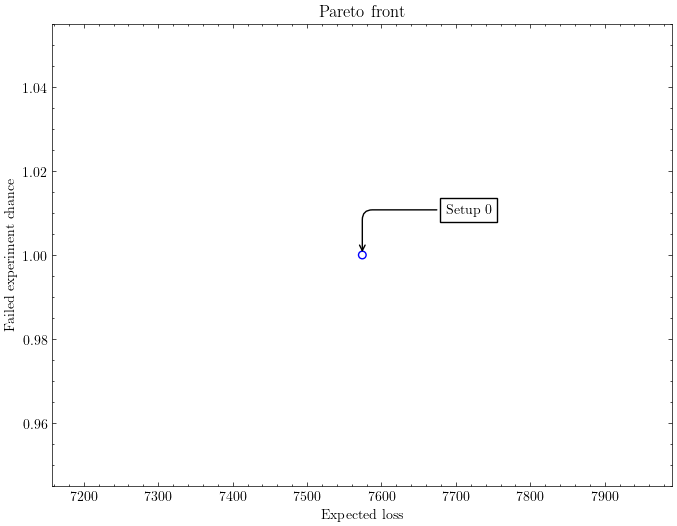

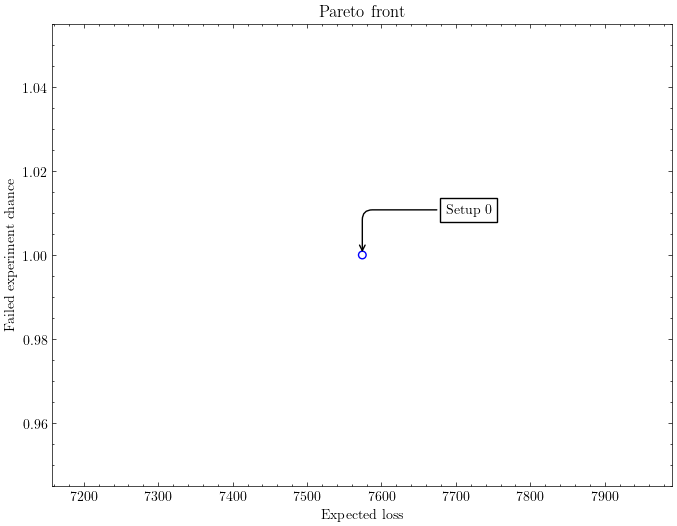

In [4]:
graph_manager.build_pareto(res.F)
graph_manager.draw()

graph_manager.build_pareto(res.F)

display_str = input("Enter setup to display [Q to quit]: ")
while display_str.isnumeric():
    (
        proposed_layout,
        true_temps,
        model_temps,
        sensor_values,
    ) = experiment.get_SOO_plotting_arrays(res.X[int(display_str)])
    print("\nLoss:", experiment.calc_moo_loss(res.X[int(display_str)]))
    graph_manager.build_2D_compare(grid, proposed_layout, true_temps, model_temps)
    graph_manager.draw()
    display_str = input("Enter setup to display [Q to quit]: ")